In [ ]:
!pip install --upgrade openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.6
    Uninstalling openai-1.59.6:
      Successfully uninstalled openai-1.59.6


In [ ]:
from config import OPENAI_API_KEY
import openai
from openai import OpenAI




# ----------------------------
# CONFIGURATION AND CONSTANTS
# ----------------------------
MODEL_NAME = "o3-mini"
MAX_TURNS = 5

CLIMATE_SUMMARIES = {
    "Argyre": "Experiences extreme weather events that would delay climate modeling. "
              "Sensing equipment would need to be dismantled frequently, making the project take 2-3 times longer.",
    "Casius": "May hold key insights into irreversible climate change. Provides data that could help understand "
              "climate change dynamics on Earth.",
    "Diacria": "Has very consistent, non-variable climate conditions. Would take 10+ years to build an accurate "
               "climate model due to lack of atmospheric fluctuations.",
    "Eridania": "Climate has been extensively mapped by Curiosity rover. Contains fascinating cloud patterns that "
                "could unlock secrets of Martian climate."
}

LIFE_SCIENCE_SUMMARIES = {
    "Argyre": "No evidence of surface lakes or streams. Unlikely to find fossils in dusty sands.",
    "Casius": "High methane concentrations suggest potential for living organisms. Evidence of a subglacial lake "
              "makes it a top priority for finding life.",
    "Diacria": "Trace methane amounts make it disappointing for life discovery. However, potential hydrothermal "
               "pools and subsurface water reservoir exist.",
    "Eridania": "Found complex organic compounds in mudstone rocks similar to those associated with microbial life "
                "on Earth. Very cold, reducing life probability."
}

GEOLOGY_SUMMARIES = {
    "Argyre": "Boring geological landscape. However, nearby is an immense canyon system extending a quarter of the planet's circumference.",
    "Casius": "Porous surface ideal for core exploration. Experiences mild earthquakes. No nearby volcanoes of interest.",
    "Diacria": "Contains three enormous volcanoes. Provides unique access to tectonic and core data. Many unmapped surface areas.",
    "Eridania": "Difficult to collect rock samples due to solid stone upper crust. Rich in impact craters, offering insights into Mars' geological history."
}


def climate_scientist_goals():
    return """Your role is the Climate Scientist. Your goals:
1. Determine if life exists or ever existed on Mars.
2. Understand the geology of Mars.
3. Understand the atmosphere and climate dynamics on Mars.
Remember: Scientific Discovery, Life, Geology, Climate
"""


def life_scientist_goals():
    return """Your role is the Life Scientist. Your goals:
1. Determine if life exists or ever existed on Mars.
2. Understand the geology of Mars.
3. Understand the atmosphere and climate dynamics on Mars.
Remember: Scientific Discovery, Life, Geology, Climate
"""


def geology_scientist_goals():
    return """Your role is the Geology Scientist. Your goals:
1. Determine if life exists or ever existed on Mars.
2. Understand the geology of Mars.
3. Understand the atmosphere and climate dynamics on Mars.
Remember: Scientific Discovery, Life, Geology, Climate
"""


# Agent configuration
AGENTS = {
    "climate": {
        "role": "Climate Scientist",
        "goals": climate_scientist_goals(),
        "summaries": CLIMATE_SUMMARIES,
        "decider_instructions": "You are the climate scientist. Decide if you have more to contribute or if you should give a final answer. If the conversation seems near conclusion, finalize your answer.",
        "conversation_instructions": "You are the climate scientist. Discuss possible landing sites focusing on climate feasibility and advantages or disadvantages of each location."
    },
    "life": {
        "role": "Life Scientist",
        "goals": life_scientist_goals(),
        "summaries": LIFE_SCIENCE_SUMMARIES,
        "decider_instructions": "You are the life scientist. Decide if you have more to contribute or if you should finalize your recommendation. If you believe the conversation is near a decision point, finalize.",
        "conversation_instructions": "You are the life scientist. Discuss what sites have the highest potential for discovering life. Focus on methane, organic compounds, and water."
    },
    "geology": {
        "role": "Geology Scientist",
        "goals": geology_scientist_goals(),
        "summaries": GEOLOGY_SUMMARIES,
        "decider_instructions": "You are the geology scientist. Decide if you have more to contribute or if you should finalize your recommendation. If the conversation seems conclusive, finalize.",
        "conversation_instructions": "You are the geology scientist. Discuss which site offers the best geological research opportunities. Highlight volcanoes, tectonics, and crater analysis."
    }
}


# Initialize the OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)


def call_openai_model(messages, model=MODEL_NAME, temperature=0.7):
    """
    Calls the OpenAI chat completion model with the given messages.
    """
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature
    )
    return response.choices[0].message.content


def transform_history_for_agent(agent_key, conversation_history):
    """
    Transform the conversation history from the perspective of the current agent:
    - system messages remain "system"
    - messages from this agent become "assistant"
    - messages from other agents become "user"
    """
    transformed = []
    for msg in conversation_history:
        if msg["role"] == "system":
            transformed.append({"role": "system", "content": msg["content"]})
        else:
            if msg.get("name") == agent_key:
                # Current agent's own previous messages are assistant messages
                transformed.append({"role": "assistant", "content": msg["content"]})
            else:
                # All other agents' messages become user messages
                transformed.append({"role": "user", "content": msg["content"]})
    return transformed


def agent_decider(agent_key, conversation_history):
    """
    The decider model: decides if the agent should continue contributing or finalize.
    Returns either 'CONTRIBUTE' or 'FINALIZE'.
    """
    agent_data = AGENTS[agent_key]
    recent_history = conversation_history[-10:]

    # Construct prompt
    prompt = [
        {"role": "system", "content": agent_data["goals"]},
        {"role": "system", "content": agent_data["decider_instructions"]},
        {"role": "user", "content": "Given the conversation so far, should you contribute more or finalize your recommendation? Respond ONLY with 'CONTRIBUTE' or 'FINALIZE'."}
    ]

    transformed_history = transform_history_for_agent(agent_key, recent_history)
    prompt.extend(transformed_history)

    decision = call_openai_model(prompt, model=MODEL_NAME, temperature=0.0)
    return "FINALIZE" if "FINALIZE" in decision.upper() else "CONTRIBUTE"


def agent_conversation(agent_key, conversation_history, finalize=False):
    """
    The conversation model for the agent: either continue discussion or provide a final answer.
    """
    agent_data = AGENTS[agent_key]

    # User message depends on whether we are finalizing or not
    user_message = "Please provide your final recommended landing site and a brief justification." if finalize else \
        "Please continue the discussion considering the other scientists' points."

    # Select summaries based on agent role
    if agent_key == "climate":
        summaries_content = f"Climate:\n{CLIMATE_SUMMARIES}"
    elif agent_key == "life":
        summaries_content = f"Life:\n{LIFE_SCIENCE_SUMMARIES}"
    elif agent_key == "geology":
        summaries_content = f"Geology:\n{GEOLOGY_SUMMARIES}"
    else:
        summaries_content = "No summaries available."

    transformed_history = transform_history_for_agent(agent_key, conversation_history)

    prompt = [
        {"role": "system", "content": agent_data["goals"]},
        {"role": "system", "content": agent_data["conversation_instructions"]},
        {"role": "system", "content": f"Here are location-specific summaries:\n{summaries_content}"},
        {"role": "system", "content": "You are part of a team of three scientists (climate, life, geology). "
                                      "The conversation is about choosing the best landing site on Mars for your mission. "
                                      "Keep your replies short. Talk only from your perspective."}
    ]
    prompt.extend(transformed_history)
    prompt.append({"role": "user", "content": user_message})

    return call_openai_model(prompt, model=MODEL_NAME, temperature=0.7)


def run_conversation(MAX_TURNS = 10):
    """
    Run a round-robin conversation among the three agents until all finalize or max turns reached.
    """
    conversation_history = []
    finalized = {"climate": False, "life": False, "geology": False}

    # Initial system prompt
    conversation_history.append({
        "role": "system",
        "content": "You are three scientists discussing where to land on Mars. "
                    "Consider climate, life potential, and geology to select the best site. Start the conversation now."
    })

    agent_order = ["climate", "life", "geology"]
    turn = 0

    while turn < MAX_TURNS:
        # If all have finalized, stop
        if all(finalized.values()):
            break

        for agent_key in agent_order:
            # Skip agents that have already finalized
            if finalized[agent_key]:
                continue

            decision = agent_decider(agent_key, conversation_history)
            if decision == "FINALIZE":
                response = agent_conversation(agent_key, conversation_history, finalize=True)
                finalized[agent_key] = True
            else:
                response = agent_conversation(agent_key, conversation_history, finalize=False)

            conversation_history.append({"role": "assistant", "name": agent_key, "content": response})

            if decision == "FINALIZE":
                finalized[agent_key] = True

        turn += 1

    return conversation_history

In [ ]:
final_conversation = run_conversation(MAX_TURNS = 10)

BadRequestError: Error code: 400 - {'error': {'message': "Unsupported parameter: 'temperature' is not supported with this model.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_parameter'}}

In [ ]:
def extract_final_choice(conversation):
    """
    After the conversation ends, call the EXTRACTOR agent to determine the team's final chosen location.
    The EXTRACTOR should respond with one word: the chosen location or 'ERROR' if unclear.
    """

    # We'll just feed the entire conversation to the model and ask for a single-word summary.
    # The conversation includes system, assistant messages from each agent.
    # We trust that by the end of the conversation, a final decision was made.

    # Transform the entire final conversation so the EXTRACTOR sees them as a single user-provided text.
    # The EXTRACTOR is a separate "system" persona with a simple rule.
    conversation_content = ""
    for msg in conversation:
        # We'll just include all messages. The EXTRACTOR should figure out the final location.
        # It's safe to give them all in user role so it tries to extract from user perspective.
        # Or we can just present them as assistant content one after another.
        conversation_content += f"{msg.get('name', msg['role']).upper()}: {msg['content']}\n\n"

    extractor_prompt = [
        {"role": "system", "content": "You are the EXTRACTOR agent. You will read the entire conversation and determine the final chosen landing location on Mars."},
        {"role": "system", "content": "Output only one word: the chosen site name (e.g., 'Casius', 'Argyre', 'Diacria', 'Eridania') if a single final choice is clear. Otherwise, output 'ERROR'."},
        {"role": "user", "content": "Here is the entire conversation:\n" + conversation_content}
    ]

    response = call_openai_model(extractor_prompt, model=MODEL_NAME, temperature=0.0)
    # Just in case, strip whitespace
    final_choice = response.strip()
    # Ensure it's one word or 'ERROR'
    # If not sure, return 'ERROR'
    if final_choice not in ["Argyre", "Casius", "Diacria", "Eridania", "ERROR"]:
        final_choice = "ERROR"
    return final_choice

In [ ]:
final_conversation

[{'role': 'system',
  'content': 'You are three scientists discussing where to land on Mars. Consider climate, life potential, and geology to select the best site. Start the conversation now.'},
 {'role': 'assistant',
  'name': 'climate',
  'content': "Given the climate perspectives at each site:\n\n1. **Argyre**: From a climate standpoint, Argyre's extreme weather would significantly delay our ability to model the climate accurately, as the sensing equipment would frequently need to be dismantled. This could hinder our understanding of the climate dynamics on Mars. \n\n2. **Casius**: Offers an opportunity to study irreversible climate change, which could be crucial for understanding both Martian and potentially Earth climates. The data here could yield valuable insights into climate change dynamics.\n\n3. **Diacria**: Has a very stable climate, but the lack of variability means it would take over a decade to build a comprehensive climate model. This might not be ideal if we're looking

In [ ]:
extract_final_choice(final_conversation[-3:])

NameError: name 'final_conversation' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming run_conversation() and extract_final_choice() are defined as in previous code

final_choices = []
num_simulations = 10

for i in range(num_simulations):
    final_conversation = run_conversation()
    choice = extract_final_choice(final_conversation)
    final_choices.append(choice)
    print(f"{i}. {choice}")

0. Casius
1. Casius
2. Diacria
3. Casius
4. Casius
5. Casius
6. Casius
7. Casius
8. Casius
9. Casius


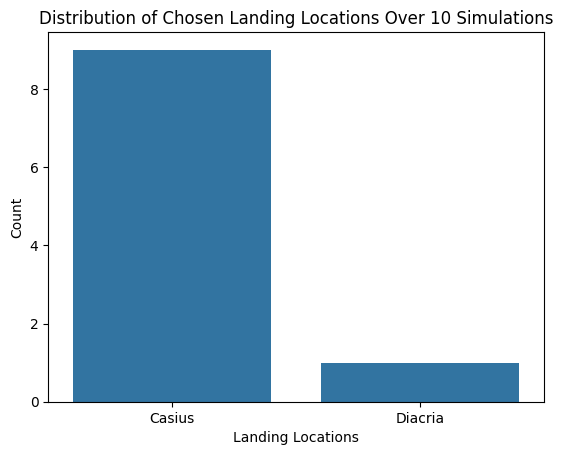

In [ ]:
final_choices
sns.countplot(x=final_choices)
plt.xlabel("Landing Locations")
plt.ylabel("Count")
plt.title("Distribution of Chosen Landing Locations Over 10 Simulations")
plt.show()

In [ ]:
import asyncio
from config import OPENAI_API_KEY
import openai
from openai import AsyncOpenAI
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# CONFIGURATION AND CONSTANTS
# ----------------------------
openai.api_key = OPENAI_API_KEY
MODEL_NAME = "o3-mini"

# Templates for instructions
GOALS_TEMPLATE = {
    "Scientist": """Your role is the {role_mts}. Your goals:
    These are the factors you need to consider when deciding which location will best
support the Mars science goals:
1. Maximize chances for scientific discoveries
2. Determine if life exists or ever existed on Mars.
3. Understand the geology of Mars.
4. Understand the atmosphere and climate dynamics on Mars.
5. Consider perspectives of others and find location that is good for both scientific discoveries and habitation support.
Remember: Scientific Discovery, Life, Geology, Climate.
Be more mindful about others. the goal of the collaboration is to select landing location that will benefit the whole mission.mat
""",
    "Economist": """Your role is the {role_mts}. Your goals:
    These are the factors you need to consider when deciding which location will best
support the Mars mission from an economic perspective:
1. Evaluate the cost efficiency and budget implications of each potential landing site.
2. Assess the economic viability and potential for long-term financial sustainability.
3. Analyze resource availability and the prospects for in-situ resource utilization.
4. Balance investment risks with the anticipated returns and overall economic benefits.
5. Consider broader stakeholder perspectives to ensure the selected site supports both economic prudence and mission success.
Remember: Cost Efficiency, Economic Viability, Investment, Resource Management.
Strive to select a landing location that provides a strong economic foundation for the entire mission.
"""




}


DECIDER_INSTRUCTIONS_TEMPLATE = "You are the {role_mts}. Decide if you have more to contribute or finalize your answer. Respond 'CONTRIBUTE' or 'FINALIZE'."
CONVERSATION_INSTRUCTIONS_TEMPLATE = "You are the {role_mts}. Discuss the best landing site on Mars given your domain expertise."

AGENTS = {
    "climate": {
        "role_mts": "Climate Scientist",
        "summaries": {
            "Climate": {
                "Argyre": '''

                Support:
                -None

                Against:
                 - Experiences extreme weather events that would delay climate modeling
                 - Sensing equipment would need to be dismantled frequently, making the project take 2-3 times longer.
                '''
               ,

                "Casius": '''

                Support:
                  - May hold key insights into irreversible climate change
                  - Provides data that could help understand climate change dynamics on Earth."

                Against:
                  -None

                ''',

                "Diacria": '''

                 Support:
                 -Locating the colony in Diacria is valuable for Mars climate mapping because its central position grants access to unexplored areas that Curiosity couldn’t reach, providing essential climate data.


                Against:
                - Has very consistent, non-variable climate conditions, which is bad for data collection
                - Would take 10+ years to build an accurate climate model due to lack of atmospheric fluctuations.",

                ''',

                "Eridania": '''

                Support:
                - Contains fascinating cloud patterns that could unlock secrets of Martian climate.

                Against:
                - Climate has been extensively mapped by Curiosity rover.

                '''
            }
        }
    },
    "life": {
        "role_mts": "Life Scientist",
        "summaries": {
            "Life": {
                "Argyre": '''

                Support:
                -Argyre provides easy access to high carbon concentration, a building block of life.

                Against:
                -No evidence of surface lakes or streams.
                -Unlikely to find fossils in dusty sands.",


                ''',
                "Casius":'''

                 Support:
                   -High methane concentrations suggest potential for living organisms.
                   -Evidence of a subglacial lake makes it a top priority for finding life.
                 Against:
                  - No lava tubes at or within a reasonable driving distance from Casius, a major setback for scientists who are eager to explore these lava tubes for signs of life.

                ''',
                "Diacria": '''

                Support:
                -potential hydrothermal pools exist, which may provide places for life
                -Subsurface water reservoir exist, which may provide places for life


                Against:
                -Trace methane amounts make it disappointing for life discovery

                ''',
                "Eridania":'''

                Support:
                 - Found complex organic compounds in mudstone rocks similar to those associated with microbial life on Earth.
                 - Eridania, near a Martian pole with abundant ice, is a top priority for searching for evidence of life.

                Against:
                 -Very cold, reducing life probability
                '''
            }
        }
    },
    "geology": {
        "role_mts": "Geology Scientist",
        "summaries": {
            "Geology": {
                "Argyre": '''


                Support:
                -Nearby is an immense canyon system extending a quarter of the planet's circumference

                Against:
                - No mountains, volcanoes, and valleys in this location
                - Frequent gusts would interfere with major equipment, including seismometers, needed to create a 3D map of the deep interior of Mars.


                ''',
                "Casius": '''


                Support:
                -Porous surface ideal for core exploration
                -Casius experiences mild but fascinating earthquake, which are a geology treasure trove for scientists.

                Against:
                - No nearby volcanoes of interest

                ''',
                "Diacria": '''


                Support:
                -Contains three enormous volcanoes, which porovides unique access to tectonic and core data
                -Many unmapped surface areas.
                Against:
                -None


               ''',
                "Eridania":'''

                Support:
                -Rich in impact craters, offering insights into Mars' geological history.

                Against:
                -Difficult to collect rock samples due to solid stone upper crust.
                -Eridania is quite far from these known blind spots and there would not be an opportunity to map them out, which is bad for understanding geology

           '''
            }
        }
    },
  "water": {
        "role_mts": "Water Specialist",
        "summaries": {
            "Water": {
                "Argyre": '''

                Support:
                -Subglacial lake accessible

                Against:
                -Unusual layer of stone that would make it very difficult to create an underground liquid water reservoir




                ''',

                "Casius": '''

                Support:
                -underground water reserves recently discovered

                Against:
                -Deep water reserves difficult to access.
                ''',

                "Diacria": '''

                Support:
                -there will be a long-term water supply available from subglacial lake
                -Olympus Mons provides abundant ice water reserves that if they could be harnessed, could refresh Diacria’s water supply.

                Against:
                -Long replenishment times for water reserves

                ''',

                "Eridania": '''


                Support:
                -High water reserves would provide all the water the crew needs
                -Liquid water flows intermittently on present day Eridania
                -Significant concentration of water ice in the upper meter of the Martian Surface

                Against:
                -limited sunlight and buried glacial ice increases harvesting difficulty

                '''
            }
        }
    },
    "terrain": {
        "role_mts": "Terrain Specialist",
        "summaries": {
            "Terrain": {
                "Argyre":'''

                Support:
                -Argyre's magnesium-rich soil prevents water from freezing, making it easier for the crew to live there.
                -Argyre’s water reserve is located very close to a nearby crater which would be ideal for placing a subsurface habitat

                Against:
                -The soil’s chemical makeup makes extracting water ice from Argyre’s subglacial lake challenging.

                '''        ,
                "Casius":'''

               Support":
               -Casius's soft soil might allow the colony to build an underground well or water holding tank.


               Against:
                -High elevation complicates landing and living conditions.
                -Geologic evidence indicates that Casius' water reserve lies in a broad, flat area, which means the crew would need to live entirely above ground, which would expose team to cosmic radiation

              ''',

                "Diacria": '''

                Support:
                -Ideal for underground habitats and lava tube exploration
                -unusually soft soil that would make it easy to create an underground liquid water reservoir just below the debris layer.
                -Low elevation aids in landings

                Against:
                -Toxic chlorine in soil causes water to need energy-intensive dechlorination

                ''',
                "Eridania": '''




                Support:
                -Even layer of glacial water ice located relatively close to the surface in this location, easy to access

                Against:
                -Solid stone crust increases challenges for habitat construction and water access


                '''
            }
        }
    },
    "atmosphere": {
        "role_mts": "Atmospheric Specialist",
        "summaries": {
            "Atmosphere": {
                "Argyre": '''

                Support:
                -Argyre's moderate climate enables Moxie to efficiently convert Mars' CO2 into breathable air.
                -Argyre receives the most sunlight among the candidate sites, making it ideal for powering the crew’s habitat, rovers, and scientific instruments.
                Against:
                -None

                ''',
                "Casius": '''

                Support
                -None

                Against
                -Extreme temperature fluctuations limit air production capabilities.
                -Low sunlight hinders energy harvesting.

                ''',
                "Diacria":'''

                Support:
                -Optimal atmospheric carbon dioxide levels for air production
                Against:
                -None
                ''',


                "Eridania": '''

                Support:
                -None

                Against:
                -High particulate matter disrupts air production systems
                -Limited sunlight for energy harvesting
                  '''
            }
        }
    }
}


In [ ]:
client = AsyncOpenAI(api_key=OPENAI_API_KEY)

async def call_openai_model(messages, model=MODEL_NAME):
    response = await client.chat.completions.create(
        model=model,
        messages=messages,
    )
    return response.choices[0].message.content

def transform_history_for_agent(agent_key, conversation_history):
    """
    Transform the conversation history from the perspective of the current agent:
    - system messages remain "system"
    - messages from this agent become "assistant"
    - messages from other agents become "user"
    """
    transformed = []
    for msg in conversation_history:
        if msg["role"] == "system":
            transformed.append({"role": "system", "content": msg["content"]})
        else:
            if msg.get("name") == agent_key:
                transformed.append({"role": "assistant", "content": msg["content"]})
            else:
                transformed.append({"role": "user", "content": msg["content"]})
    return transformed

def get_agent_instructions(agent_key, agents):
    """
    Given an agent key, produce the goals, decider_instructions, and conversation_instructions
    by formatting the templates with the agent's role_mts.
    """
    role_mts = agents[agent_key]["role_mts"]

    if "Scientist" in role_mts:
        goals = GOALS_TEMPLATE['Scientist'].format(role_mts=role_mts)
    else:
        goals = GOALS_TEMPLATE['Economist'].format(role_mts=role_mts)

    decider_instructions = DECIDER_INSTRUCTIONS_TEMPLATE.format(role_mts=role_mts)
    conversation_instructions = CONVERSATION_INSTRUCTIONS_TEMPLATE.format(role_mts=role_mts)
    return goals, decider_instructions, conversation_instructions


async def agent_conversation(agent_key, agents, conversation_history, finalize=False):
    """
    Agent produces either more discussion or a final answer.
    """
    goals, _, conversation_instructions = get_agent_instructions(agent_key, agents)
    agent_data = agents[agent_key]
    user_message = "Please provide your final recommended landing site and a brief justification." if finalize \
        else "Please continue the discussion considering the other scientists' points."

    # Construct summaries message
    combined_summaries = ""
    for summary_type, summary_dict in agent_data["summaries"].items():
        combined_summaries += f"{summary_type}:\n{summary_dict}\n"

    transformed_history = transform_history_for_agent(agent_key, conversation_history)

    prompt = [
        {"role": "system", "content": goals},
        {"role": "system", "content": conversation_instructions},
        {"role": "system", "content": f"Here are location-specific summaries:\n{combined_summaries}"},
        {"role": "system", "content": "You are part of a team of scientists discussing the best landing site on Mars. Keep replies short. Talk only from your perspective."}
    ]
    prompt.extend(transformed_history)
    prompt.append({"role": "user", "content": user_message})

    return await call_openai_model(prompt, model=MODEL_NAME)

import random

async def run_conversation(agents, MAX_TURNS=10):
    """
    Run a round-robin conversation among the given agents until all finalize or max turns reached.
    """
    conversation_history = []
    finalized = {agent_key: False for agent_key in agents.keys()}

    # Initial system prompt
    conversation_history.append({
        "role": "system",
        "content": "You are a team of scientists discussing where to land on Mars. Make sure to not forget about scientific discovery. Start now."
    })

    agent_order = list(agents.keys())
    random.shuffle(agent_order)  # Randomize the agent order

    turn = 0

    max_turns_per_agent = MAX_TURNS // len(agents)  # Split MAX_TURNS equally among agents

    while turn < MAX_TURNS:
        if all(finalized.values()):
            break

        for agent_key in agent_order:
            if finalized[agent_key]:
                continue

            # Check if the agent should finalize based on max_turns_per_agent
            finalize = turn >= max_turns_per_agent

            # Each agent either continues or finalizes
            response = await agent_conversation(agent_key, agents, conversation_history, finalize=finalize)
            conversation_history.append({"role": "assistant", "name": agent_key, "content": response})

            # Mark the agent as finalized if they have contributed enough turns
            if finalize:
                finalized[agent_key] = True

        turn += 1

    return conversation_history


async def extract_final_choice(conversation):
    """
    Extract final chosen landing location or 'ERROR'.
    """
    conversation_content = ""
    last_messages = conversation[-10:]
    for msg in conversation:
        conversation_content += f"{msg.get('name', msg['role']).upper()}: {msg['content']}\n"

    extractor_prompt = [
        {"role": "system", "content": "You are the EXTRACTOR. Determine final chosen landing site from the conversation."},
        {"role": "system", "content": "Output only one word: 'Argyre', 'Casius', 'Diacria', 'Eridania', or 'ERROR'."},
        {"role": "user", "content": f"CONVERSATION:\n{conversation_content}"}
    ]

    response = await call_openai_model(extractor_prompt, model=MODEL_NAME)
    final_choice = response.strip()
    if final_choice not in ["Argyre", "Casius", "Diacria", "Eridania"]:
        final_choice = "ERROR"
    return final_choice

async def run_single_simulation(i, agents):
    conv = await run_conversation(agents, MAX_TURNS=15)
    choice = await extract_final_choice(conv)
    print(f"simulation {i}, choice: {choice}")
    return choice




In [ ]:
MODEL_NAME = "o3-mini"
await run_single_simulation(1, agents=AGENTS)

simulation 1, choice: Diacria


'Diacria'

In [ ]:
agents_science = {key: value for key, value in AGENTS.items() if key in ["climate", "life", "geology"]}
agents_economist = {key: value for key, value in AGENTS.items() if key in ["budget", "investment", "resource"]}

In [ ]:
async def run_n_simulations(num_simulations = 10, agents = AGENTS):
    # Run simulations in parallel
    results = await asyncio.gather(*(run_single_simulation(i, agents) for i in range(num_simulations)))
    print("All simulations complete:")
    print(results)

In [ ]:
MODEL_NAME = "o3-mini"
mts_results = await run_n_simulations(num_simulations = 10, agents = AGENTS)

simulation 6, choice: Diacria
simulation 8, choice: Diacria
simulation 2, choice: Argyre
simulation 5, choice: Eridania
simulation 3, choice: Argyre
simulation 9, choice: Casius
simulation 7, choice: Eridania
simulation 1, choice: Diacria
simulation 0, choice: Diacria
simulation 4, choice: ERROR
All simulations complete:
['Diacria', 'Diacria', 'Argyre', 'Argyre', 'ERROR', 'Eridania', 'Diacria', 'Eridania', 'Diacria', 'Casius']


In [ ]:
mts_results

None


In [ ]:
['Argyre', 'Argyre', 'Argyre', 'Argyre', 'Argyre', 'Casius', 'Casius', 'Casius', 'Casius', 'Casius', 'Casius']

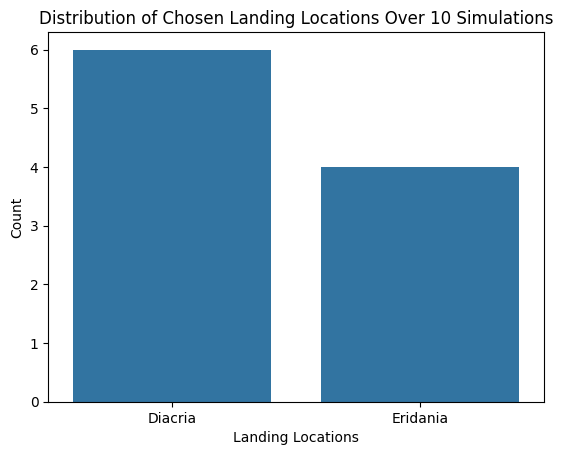

In [ ]:
# Create a bar chart of final choices
sns.countplot(x=['Diacria', 'Diacria', 'Eridania', 'Diacria', 'Eridania', 'Diacria', 'Eridania', 'Diacria', 'Eridania', 'Diacria']



)
plt.xlabel("Landing Locations")
plt.ylabel("Count")
plt.title("Distribution of Chosen Landing Locations Over 10 Simulations")
plt.show()